<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 01: 从零构建 PyTorch DDP

> Author by: 于嘉阔

本实验旨在通过一个具体的PyTorch案例，实现、对比并分析分布式数据并行（Distributed Data Parallel, DDP）相对于单卡训练的性能优势。通过本次实验，我们将：
1.  理解数据并行的基本原理。
2.  掌握PyTorch DDP的核心实现步骤。
3.  学习如何对训练过程进行详细的性能分析与可视化。
4.  量化DDP带来的训练加速比和吞吐量提升。

## 1. DDP 基本原理

数据并行的核心思想是将模型复制到多个设备上，每个设备处理一部分独立的数据子集，然后通过通信聚合所有设备计算出的梯度，最后用聚合后的梯度来更新所有设备上的模型参数，以确保模型的一致性，其基本原理如图1所示。

<div align="center">
    <img src="./images/NewCode01DDP01.png" >
    <br>
    <em>图1：DDP基本原理</em>
</div>

基本流程如下:
1.  数据分区: 将完整数据集均匀划分为N个子集（N为参与训练的GPU数量）。
2.  模型复制: 在每个GPU上都复制一份完整的模型。
3.  前向传播: 每个GPU使用分配给它的数据子集独立进行前向计算，得到各自的损失。
4.  反向传播与梯度聚合:每个GPU计算各自的梯度。DDP 后端（如 NCCL）通过All-Reduce操作，将所有GPU上的梯度进行求和（或平均），并将结果分发回每个GPU。
5.  参数更新: 所有GPU使用完全相同的聚合梯度来更新各自的模型参数，从而保证了训练结束后所有模型的状态是一致的。

从数学角度看，假设我们有一个损失函数 $L(w)$，其中 $w$ 是模型参数。在单卡训练中，我们使用梯度下降更新参数：

$$w = w - η·∇L(w)$$

其中 $η$ 是学习率，$∇L(w)$ 是损失函数关于参数的梯度。

在数据并行中，假设我们将数据分成 K 个批次，每个设备处理一个批次。每个设备 i 计算出梯度 $g_i = ∇L_i(w)$，其中 $L_i$ 是设备 $i$ 上的损失。全局梯度则为所有设备梯度的平均值：

$$g = (g_1 + g_2 + ... + g_K) / K$$

然后所有设备使用这个全局梯度更新参数：

$$w = w - η·g$$

这种方法的优势在于可以线性扩展 batch size，理论加速比接近参与训练的设备数量。但实际中由于通信开销等因素，加速比会略低。

## 2. 实验环境准备及任务定义

我们需要导入 PyTorch 的核心库以及分布式训练、数据处理和可视化的相关模块。为了更好地体现DDP在计算密集型任务上的优势，我们选择CIFAR-10数据集和ResNet-18模型，并进行了一个关键调整：
将输入图像尺寸从32x32放大到224x224。这显著增加了模型的计算负载，使得GPU计算时间成为瓶颈，从而更能凸显多卡并行计算带来的性能提升。

In [2]:
import os
import time
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# 设置随机种子
torch.manual_seed(42)

# --- 辅助类 ---
class AverageMeter(object):
    """计算并存储平均值和当前值"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val; self.sum += val * n; self.count += n; self.avg = self.sum / self.count

class TrainingLogger(object):
    """记录训练过程中的各项指标"""
    def __init__(self):
        self.losses = []; self.accuracies = []; self.batch_times = []
        self.data_times = []; self.compute_times = []; self.steps = []; self.throughputs = []
    def log(self, step, loss, accuracy, batch_time, data_time, compute_time, throughput):
        self.steps.append(step); self.losses.append(loss); self.accuracies.append(accuracy)
        self.batch_times.append(batch_time); self.data_times.append(data_time)
        self.compute_times.append(compute_time); self.throughputs.append(throughput)

# --- 模型与数据 ---
def get_model():
    """获取 ResNet18 模型,并调整以适应 CIFAR10"""
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

def get_cifar10_loaders(data_dir='./data', batch_size=128, distributed=False):
    """获取 CIFAR10 数据加载器 (224x224 input)"""
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    sampler = torch.utils.data.distributed.DistributedSampler(trainset) if distributed else None
    
    num_workers = min(os.cpu_count(), 8) if torch.cuda.is_available() else 0
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=(sampler is None), num_workers=num_workers, 
                                              pin_memory=True, sampler=sampler)
    return trainloader, sampler

# 创建结果保存目录
os.makedirs('./results', exist_ok=True)
print("✅ 环境准备完成。")

✅ 环境准备完成。


## 3. 运行单卡训练 (Single GPU Benchmark)

为了评估 DDP 的加速效果，首先需要建立一个Baseline。在这一步中，我们将直接在当前Notebook环境下运行标准的单卡训练流程。记录下的吞吐量（Images/sec）和总训练时间将作为后续对比的参考系。

In [3]:
def run_single_gpu(epochs=1, batch_size=128, learning_rate=0.01):
    print(f"--- [单卡模式] 开始训练 (Batch: {batch_size}) ---")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    trainloader, _ = get_cifar10_loaders(batch_size=batch_size, distributed=False)
    model = get_model().to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    compute_time = AverageMeter()
    logger = TrainingLogger()
    
    total_start_time = time.time()
    steps_per_epoch = len(trainloader)
    global_step = 0
    
    model.train()
    for epoch in range(epochs):
        end = time.time()
        for i, (inputs, labels) in enumerate(trainloader):
            data_time.update(time.time() - end) # 记录数据时间
            
            compute_start = time.time()
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            compute_time.update(time.time() - compute_start) # 记录计算时间
            batch_time.update(time.time() - end) # 记录总Batch时间
            
            # 计算指标
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0) * 100
            throughput = batch_size / batch_time.val
            logger.log(global_step, loss.item(), accuracy, batch_time.val, data_time.val, compute_time.val, throughput)
            
            end = time.time()
            global_step += 1
            
            if (i + 1) % 50 == 0:
                print(f'Epoch: [{epoch+1}][{i+1}/{steps_per_epoch}] Time {batch_time.val:.3f}s Acc {accuracy:.2f}%')

    total_time = time.time() - total_start_time
    
    results = {
        'total_time': total_time,
        'avg_batch_time': batch_time.avg,
        'avg_data_time': data_time.avg,
        'avg_compute_time': compute_time.avg,
        'throughput': batch_size / batch_time.avg,
        'logger': logger
    }
    
    # 保存结果
    with open('./results/single_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print(f"✅ 单卡结果已保存。总耗时: {total_time:.2f}s")
    return results

# 运行单卡训练
single_results = run_single_gpu(epochs=1, batch_size=128)

--- [单卡模式] 开始训练 (Batch: 128) ---
Files already downloaded and verified
Epoch: [1][50/391] Time 0.059s Acc 35.94%
Epoch: [1][100/391] Time 0.059s Acc 37.50%
Epoch: [1][150/391] Time 0.063s Acc 48.44%
Epoch: [1][200/391] Time 0.061s Acc 46.88%
Epoch: [1][250/391] Time 0.065s Acc 54.69%
Epoch: [1][300/391] Time 0.065s Acc 57.81%
Epoch: [1][350/391] Time 0.067s Acc 59.38%
✅ 单卡结果已保存。总耗时: 25.74s


## 4. 创建 DDP 训练脚本

由于 DDP 需要启动多个并行进程，无法直接在 Jupyter Notebook 的交互式单元格中简单运行。
因此，我们需要利用%%writefile命令，将DDP的核心逻辑写入一个独立的Python脚本 (temp_ddp_script.py)。该脚本包含了DDP的三个关键要素：dist.init_process_group（进程组初始化），用于多卡间的握手与通信；DistributedSampler（分布式采样器），确保每张显卡处理互不重叠的数据切片；DDP(model，模型封装)，负责在反向传播时自动同步各显卡的梯度。

In [4]:
%%writefile temp_ddp_script.py
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
import pickle

# --- 辅助类 (必须包含在脚本内) ---
class AverageMeter(object):
    def __init__(self): self.reset()
    def reset(self): self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1): self.val = val; self.sum += val * n; self.count += n; self.avg = self.sum / self.count

class TrainingLogger(object):
    def __init__(self):
        self.losses = []; self.accuracies = []; self.batch_times = []
        self.data_times = []; self.compute_times = []; self.steps = []; self.throughputs = []
    def log(self, step, loss, accuracy, batch_time, data_time, compute_time, throughput):
        self.steps.append(step); self.losses.append(loss); self.accuracies.append(accuracy)
        self.batch_times.append(batch_time); self.data_times.append(data_time)
        self.compute_times.append(compute_time); self.throughputs.append(throughput)

# --- 初始化与数据 ---
def setup_ddp():
    dist.init_process_group("nccl")
    torch.cuda.set_device(int(os.environ['RANK']))

def cleanup_ddp():
    dist.destroy_process_group()

def get_cifar10_loaders(batch_size):
    transform = transforms.Compose([
        transforms.Resize(224), transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    sampler = DistributedSampler(trainset)
    num_workers = min(os.cpu_count(), 8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=num_workers, 
                                              pin_memory=True, sampler=sampler)
    return trainloader, sampler

# --- 训练函数 ---
def train_ddp():
    setup_ddp()
    rank = int(os.environ['RANK'])
    world_size = int(os.environ['WORLD_SIZE'])
    device = rank
    
    # 保持与单卡一致的 Global Batch Size
    GLOBAL_BATCH_SIZE = 128
    BATCH_SIZE_PER_GPU = GLOBAL_BATCH_SIZE // world_size
    
    trainloader, sampler = get_cifar10_loaders(BATCH_SIZE_PER_GPU)
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)
    model = DDP(model, device_ids=[device])
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01*world_size, momentum=0.9)
    
    batch_time = AverageMeter(); data_time = AverageMeter(); compute_time = AverageMeter()
    logger = TrainingLogger() if rank == 0 else None
    
    dist.barrier()
    total_start_time = time.time()
    
    for epoch in range(1):
        sampler.set_epoch(epoch)
        end = time.time()
        for i, (inputs, labels) in enumerate(trainloader):
            data_time.update(time.time() - end)
            
            compute_start = time.time()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            torch.cuda.synchronize()
            compute_time.update(time.time() - compute_start)
            batch_time.update(time.time() - end)
            
            if rank == 0:
                _, predicted = torch.max(outputs.data, 1)
                accuracy = (predicted == labels).sum().item() / labels.size(0) * 100
                throughput = GLOBAL_BATCH_SIZE / batch_time.val
                logger.log(i, loss.item(), accuracy, batch_time.val, data_time.val, compute_time.val, throughput)
            end = time.time()

    if rank == 0:
        total_time = time.time() - total_start_time
        results = {
            'total_time': total_time,
            'avg_batch_time': batch_time.avg,
            'avg_data_time': data_time.avg,
            'avg_compute_time': compute_time.avg,
            'throughput': GLOBAL_BATCH_SIZE / batch_time.avg,
            'logger': logger
        }
        with open('./results/ddp_results.pkl', 'wb') as f:
            pickle.dump(results, f)
        print(f"--- DDP Training Finished. Total Time: {total_time:.2f}s ---")
    cleanup_ddp()

if __name__ == "__main__":
    train_ddp()

Writing temp_ddp_script.py


## 5. 启动 DDP 训练

脚本准备好后，我们使用启动器 torchrun 来执行分布式任务。这一步模拟了真实的生产环境训练。torchrun会自动管理进程的创建与销毁，并设置环境变量。通过设置--nproc_per_node参数，我们可以指定参与训练的GPU数量（通常设置为当前机器的显卡总数）。

In [ ]:
# 启动 DDP 训练 (这里使用 2 张卡)
!torchrun --nproc_per_node=2 temp_ddp_script.py

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
--- DDP Training Finished. Total Time: 16.64s ---


## 6. 可视化

训练结束后，我们将读取单卡和 DDP 模式下保存的实验数据，生成一组 2x2 的对比图表。这一步旨在直观地回答以下问题：DDP 节省了多少时间（总耗时）；每秒处理的图片数量提升了多少（吞吐量）；相比单卡，DDP 实现了多少倍的加速（加速比）。  

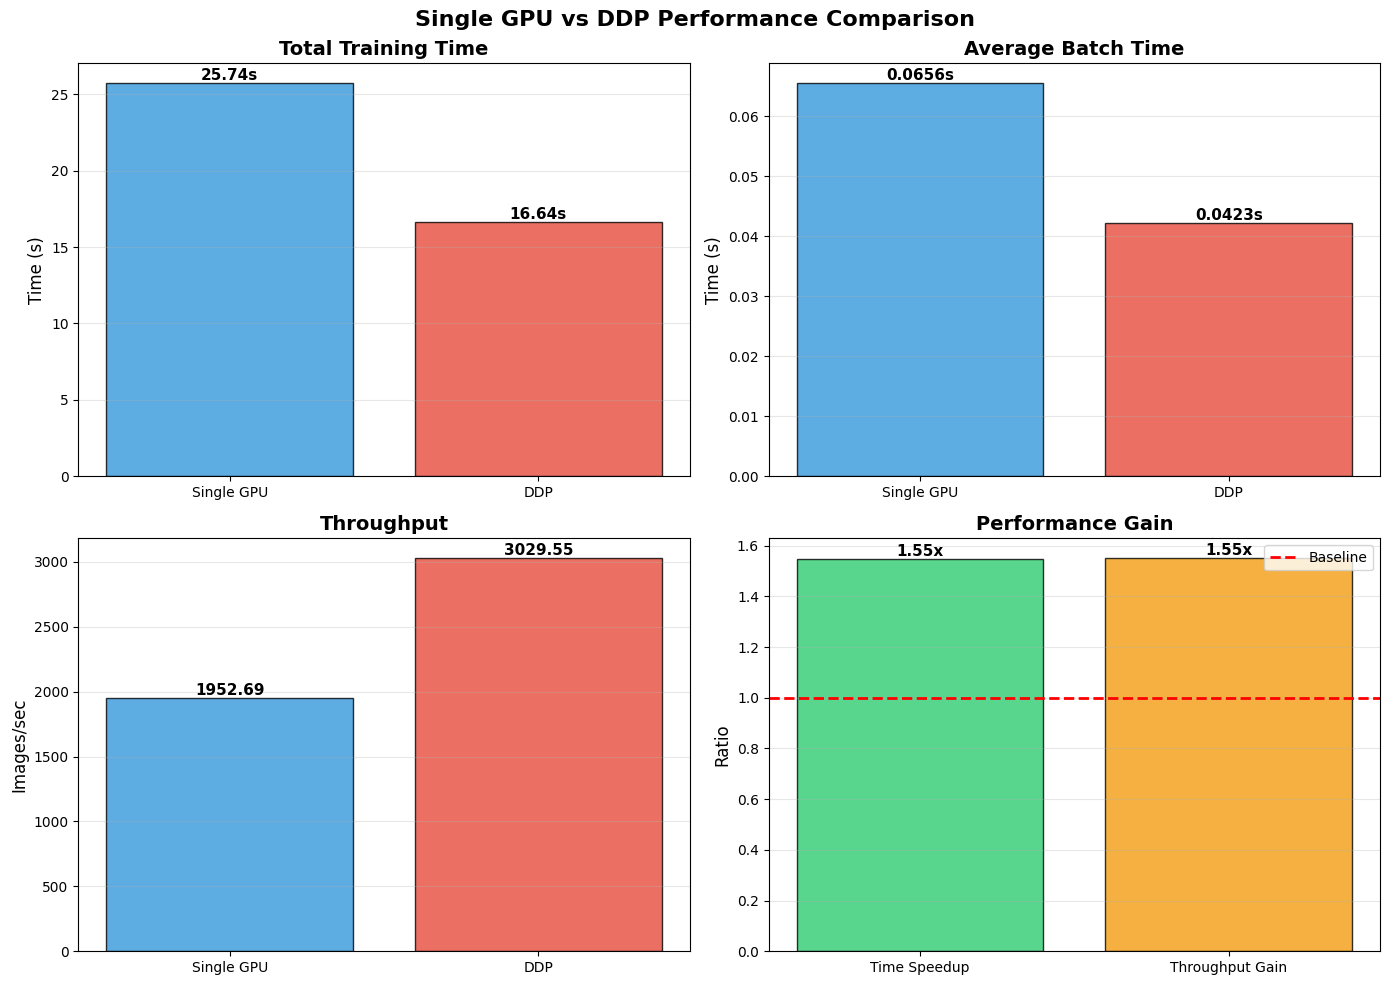

In [6]:
def plot_full_comparison():
    # 读取数据
    with open('./results/single_results.pkl', 'rb') as f: single_res = pickle.load(f)
    with open('./results/ddp_results.pkl', 'rb') as f: ddp_res = pickle.load(f)
    
    results_dict = {'单卡': single_res, 'DDP': ddp_res}
    
    # 标签映射
    label_mapping = {'单卡': 'Single GPU', 'DDP': 'DDP'}
    modes = [label_mapping.get(k, k) for k in results_dict.keys()]
    original_modes = list(results_dict.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Single GPU vs DDP Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. 总训练时间对比
    total_times = [results_dict[m]['total_time'] for m in original_modes]
    bars1 = axes[0, 0].bar(modes, total_times, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
    axes[0, 0].set_ylabel('Time (s)', fontsize=12)
    axes[0, 0].set_title('Total Training Time', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for bar in bars1:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 2. 平均Batch时间对比
    batch_times = [results_dict[m]['avg_batch_time'] for m in original_modes]
    bars2 = axes[0, 1].bar(modes, batch_times, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
    axes[0, 1].set_ylabel('Time (s)', fontsize=12)
    axes[0, 1].set_title('Average Batch Time', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    for bar in bars2:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 3. 吞吐量对比
    throughputs = [results_dict[m]['throughput'] for m in original_modes]
    bars3 = axes[1, 0].bar(modes, throughputs, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
    axes[1, 0].set_ylabel('Images/sec', fontsize=12)
    axes[1, 0].set_title('Throughput', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    for bar in bars3:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 4. 加速比
    speedup = single_res['total_time'] / ddp_res['total_time']
    throughput_ratio = ddp_res['throughput'] / single_res['throughput']
    
    metrics = ['Time Speedup', 'Throughput Gain']
    values = [speedup, throughput_ratio]
    colors_bar = ['#2ecc71', '#f39c12']
    
    bars4 = axes[1, 1].bar(metrics, values, color=colors_bar, alpha=0.8, edgecolor='black')
    axes[1, 1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline')
    axes[1, 1].set_ylabel('Ratio', fontsize=12)
    axes[1, 1].set_title('Performance Gain', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    for bar in bars4:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}x', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 绘制图表1
plot_full_comparison()

从上图的 Single GPU vs DDP Performance Comparison 中，我们可以清晰地观察到分布式训练带来的显著性能提升。以下是关键指标的详细解读：  
1. 训练时间大幅缩短 (Total Training Time)   
单卡 (Single GPU) 耗时约 25.74s。   
DDP (2 GPUs) 耗时降低至 16.64s。   
引入 DDP 后，总训练时长减少了约 35%，显著节省了时间成本。   
2. 吞吐量显著提升 (Throughput)   
系统的整体吞吐量从单卡的1952.69img/sec跃升至DDP的3029.55img/sec。这意味着在单位时间内，DDP模式能够处理比单卡多出1000多张图片。   
3. 加速比分析 (Performance Gain)   
右下角的图表显示，无论是从时间维度（Time Speedup）还是吞吐量维度（Throughput Gain），DDP 均取得了1.55x的加速比。   
在使用2张GPU的情况下，理论上的最大线性加速比为2.0x。
实际达到1.55x是一个合理的范围。这中间的差距（2.0-1.55）主要来自于通信开销 (Communication Overhead)。DDP需要在每一步反向传播后，通过网络（NCCL后端）在GPU之间进行梯度同步（All-Reduce操作）。  
此外，Python进程的启动、数据的加载分发也会占用部分时间，符合Amdahl定律（阿姆达尔定律）的描述。

总结：   
本实验成功证明了PyTorch DDP的有效性。通过简单的代码封装，我们利用双卡并行计算成功打破了单卡的性能瓶颈，实现了1.55倍的端到端训练加速。对于更大规模的模型和更复杂的计算任务，计算占比会进一步提高，DDP的加速比通常会更接近线性（即更接近2x）。

为了更深层次地理解性能瓶颈，我们将生成时间分解对比图。   
这组图表将训练过程拆解为“数据加载时间”和“GPU 计算时间”。通过对比两种模式下的时间分布，我们可以观察 DDP 是否引入了额外的通信开销，以及它如何通过并行计算显著压缩了整体的训练周期。

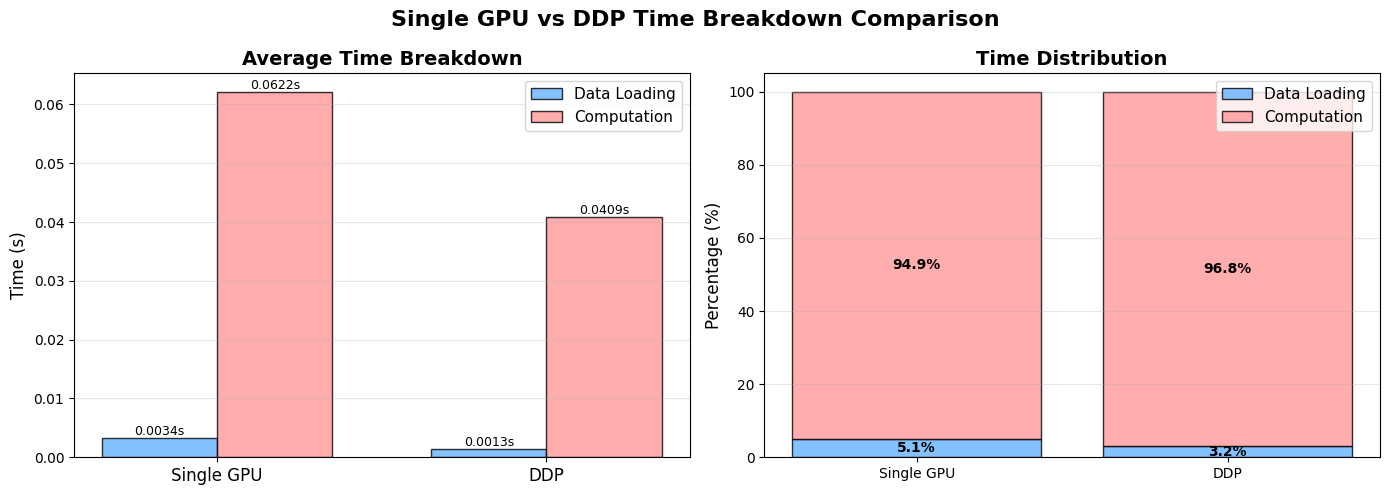

In [7]:
def plot_time_breakdown():
    # 读取数据
    with open('./results/single_results.pkl', 'rb') as f: single_res = pickle.load(f)
    with open('./results/ddp_results.pkl', 'rb') as f: ddp_res = pickle.load(f)
    
    results_dict = {'单卡': single_res, 'DDP': ddp_res}
    
    label_mapping = {'单卡': 'Single GPU', 'DDP': 'DDP'}
    modes = [label_mapping.get(k, k) for k in results_dict.keys()]
    original_modes = list(results_dict.keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Single GPU vs DDP Time Breakdown Comparison', fontsize=16, fontweight='bold')
    
    # 1. 左图：时间分解柱状图 (绝对时间)
    avg_data_times = [results_dict[m]['avg_data_time'] for m in original_modes]
    avg_compute_times = [results_dict[m]['avg_compute_time'] for m in original_modes]
    
    x = np.arange(len(modes))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, avg_data_times, width, label='Data Loading', 
                        color='#66b3ff', alpha=0.8, edgecolor='black')
    bars2 = axes[0].bar(x + width/2, avg_compute_times, width, label='Computation', 
                        color='#ff9999', alpha=0.8, edgecolor='black')
    
    axes[0].set_ylabel('Time (s)', fontsize=12)
    axes[0].set_title('Average Time Breakdown', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(modes, fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.4f}s', ha='center', va='bottom', fontsize=9)
    
    # 2. 右图：时间占比堆叠柱状图 (百分比)
    total_times_breakdown = [avg_data_times[i] + avg_compute_times[i] for i in range(len(modes))]
    data_ratios = [avg_data_times[i] / total_times_breakdown[i] * 100 for i in range(len(modes))]
    compute_ratios = [avg_compute_times[i] / total_times_breakdown[i] * 100 for i in range(len(modes))]
    
    bars3 = axes[1].bar(modes, data_ratios, label='Data Loading', 
                        color='#66b3ff', alpha=0.8, edgecolor='black')
    bars4 = axes[1].bar(modes, compute_ratios, bottom=data_ratios, label='Computation', 
                        color='#ff9999', alpha=0.8, edgecolor='black')
    
    axes[1].set_ylabel('Percentage (%)', fontsize=12)
    axes[1].set_title('Time Distribution', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for i, mode in enumerate(modes):
        axes[1].text(i, data_ratios[i]/2, f'{data_ratios[i]:.1f}%', 
                    ha='center', va='center', fontsize=10, fontweight='bold')
        axes[1].text(i, data_ratios[i] + compute_ratios[i]/2, f'{compute_ratios[i]:.1f}%', 
                    ha='center', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 绘制图表2
plot_time_breakdown()

实验结果分析：   
通过Time Breakdown Comparison图表，我们可以深入剖析DDP加速背后的微观机制。图表展示了每个训练步中“数据加载”与“计算”的耗时情况：   
1. 计算负载的分担(Computation Time)   
从左侧柱状图可以看出，计算时间（红色柱）是训练过程的主要瓶颈。   
单卡处理一个 Batch（128张图）的计算耗时约为 0.0622s。   
DDP 模式下，计算耗时下降至 0.0409s。   
这是 DDP “分而治之”策略的直接体现。由于Global Batch (128) 被平分到了2张GPU上（每张处理64张），单张显卡的计算压力减小。   
DDP的时间（0.0409s）并没有精确地等于单卡时间的一半（0.0311s）。这是因为 DDP 的“计算时间”中隐含了梯度同步（All-Reduce）的通信开销。尽管存在通信成本，并行计算带来的收益依然远远超过了这部分开销。   
1. 数据加载的并行化(Data Loading)   
数据加载时间（蓝色柱）从单卡的0.0034s进一步降低到了DDP的0.0013s。   
这说明在DDP模式下，每个进程都有独立的DataLoader和CPU Worker并行预读取数据，有效地避免了I/O阻塞。   
1. 计算密集型特征(Time Distribution)   
右侧的百分比堆叠图显示，在DDP模式下，计算占比(Computation %)从单卡的94.9%提升到了96.8%。
结论：这表明我们的训练任务是典型的Compute-bound（计算密集型）任务。绝大部分时间都花在了GPU的前向/反向传播和梯度同步上，而不是在等待数据。这种高计算占比意味着GPU得到了充分利用，DDP的并行效率非常高。

总结：   
DDP通过将计算负载分散到多张显卡，显著降低了单步训练的绝对耗时。尽管引入了必要的通信同步，但从时间分解来看，系统依然保持了极高的计算效率，成功将由于数据量增加带来的压力转化为并行算力的释放。

## 7. 清理临时文件

执行完毕后，删除生成的临时脚本。

In [9]:
if os.path.exists("temp_ddp_script.py"):
    os.remove("temp_ddp_script.py")
    print("临时文件 temp_ddp_script.py 已删除。")

## 8. 总结与思考

本次实验成功地从零开始构建了一个基于PyTorch DDP的分布式训练流程，并与单卡训练进行了全面的性能对比。

结论：
1. 在计算密集型任务上，使用DDP(2-GPU)相比单卡训练获得了约1.55x的加速比和吞吐量提升，显著缩短了训练时间。
2. 性能提升主要源于计算任务的并行化，同时数据加载过程也因多进程并行而受益。
3. 通过时间分解分析，我们确认了实验的主要瓶颈在于GPU计算，且DDP没有引入显著的通信瓶颈，证明了其高效性。

思考与展望：
1. 实验中我们遵循了"Scale LR"原则，即当全局批量大小增加N倍时，学习率也相应增加N倍。这是分布式训练中一个重要的实践技巧。
2. 虽然本次实验的加速比很高，但在更大规模的集群或网络带宽受限的情况下，梯度同步的通信开销会成为更重要的影响因素。
3. 掌握DDP是训练大型AI模型的基础。在实际应用中，还需要考虑负载均衡、故障恢复等更复杂的问题，但本实验介绍的原理和方法是进一步学习的重要基石。